# Question Generation

This is a bare bones tutorial showing what is possible with the QuestionGenerator Nodes and self.pipelines which automatically
generate questions which the question generation model thinks can be answered by a given document.

/opt/anaconda3/envs/2024_dx_bootcamp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


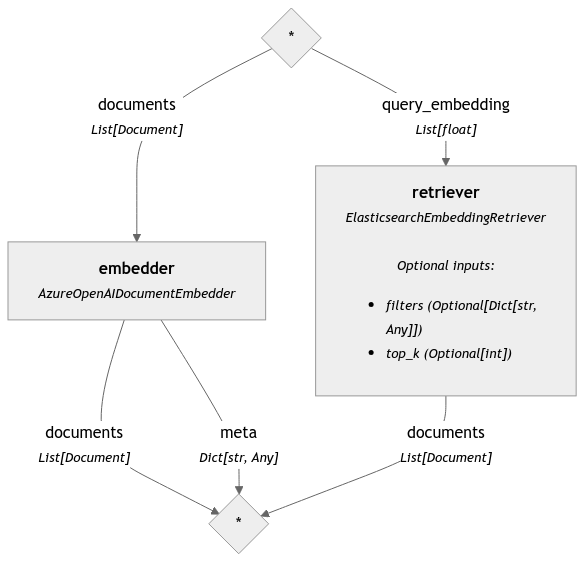

In [1]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import AzureOCRDocumentConverter
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.utils import Secret
from haystack import component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import AzureOpenAIGenerator
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack import component
from haystack import Document
import os
from dotenv import load_dotenv
from haystack.components.embedders import AzureOpenAIDocumentEmbedder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

from haystack.document_stores.types import DuplicatePolicy
from haystack import Document, Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from dotenv import load_dotenv
load_dotenv()
pipeline=Pipeline()
document_store = ElasticsearchDocumentStore()
embeder=AzureOpenAIDocumentEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                azure_deployment=os.getenv("EMBEDDING_MODEL"),meta_fields_to_embed=["summary","keywords"])
pipeline.add_component("embedder",embeder)
pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store))
pipeline.show()
# class CreateQuestionPipeline():
#     def __init__(self):
#         pass
        
#     def find_similar_documents(self,question:str):
#         pipeline=Pipeline()
#         document_store = ElasticsearchDocumentStore()
#         embeder=AzureOpenAIDocumentEmbedder(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
#                         api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
#                         azure_deployment=os.getenv("EMBEDDING_MODEL"),meta_fields_to_embed=["summary","keywords"])
#         pipeline.add_component("embedder",embeder)
#         pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store))
#         pipeline.connect("embedder.embedding", "retriever.query_embedding")
#         results = pipeline.run(query=question)
#         return results["documents"]
# check_var=CreateQuestionPipeline()
# result=check_var.find_similar_documents("What is cloud computing?")

In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import AzureOCRDocumentConverter
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.utils import Secret
from haystack import component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import AzureOpenAIGenerator
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack import component
from haystack import Document

/opt/anaconda3/envs/2024_dx_bootcamp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [ ]:
example_extract_keywords = """Documents:
Cloud computing allows users to access computing resources over the internet. It provides scalable and flexible computing services, such as storage, networking, and databases. There are several types of cloud computing: public, private, and hybrid. With cloud computing, users can deploy applications, store data, and perform computing tasks without owning or maintaining the physical infrastructure."""
keywords_sample = ["cloud computing", "scalability", "flexibility", "public cloud", "private cloud", "hybrid cloud", "internet resources"]

In [55]:
import os


@component
class SummaryKeywordFormatterPipeLine:
  """
  A component extract document summary and keywords
  """
  def __init__(self):
    self.pipeline = Pipeline()
    summary_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
    summary_template = "Give me main points of my documents. Documents:\n  {{ document }}"
    keyword_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
    keyword_template = "Give me list of keywords of my documents. Example: \n{{example_extract_keywords}}\nResult:{{keywords_sample}}} Documents:\n  {{ document }}\nResults:"
    summary_builder = PromptBuilder(template=summary_template)
    keyword_builder = PromptBuilder(template=keyword_template)
    self.pipeline.add_component("summary_builder", summary_builder)
    self.pipeline.add_component("summary_generator", summary_client)
    self.pipeline.add_component("keyword_builder", keyword_builder)
    self.pipeline.add_component("keyword_generator", keyword_client)
    self.pipeline.connect("summary_builder", "summary_generator")
    self.pipeline.connect("keyword_builder", "keyword_generator")
  @component.output_types(docs=list[Document])
  def run(self,docs=list[Document]):
    for doc in docs:
      results=self.pipeline.run({"summary_builder": {"document": doc.content},"keyword_builder": {"document": doc.content,"example_extract_keywords": example_extract_keywords,"keywords_sample": keywords_sample}},include_outputs_from=["summary_generator","keyword_generator"])
      doc.meta={"summary":results["summary_generator"]["replies"][0],"keywords":results["keyword_generator"]["replies"][0]}
    return docs
pipeline_sum=SummaryKeywordFormatterPipeLine()
check=pipeline_sum.run(docs=[Document(content="I like to play football"),Document(content="Python FastAPI is a modern web framework")])
check

method='post' url='/chat/completions' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=NOT_GIVEN json_data={'messages': [{'role': 'user', 'content': 'Give me main points of my documents. Documents:\n  I like to play football'}], 'model': 'gpt-4o', 'stream': False} extra_json=None
method='post' url='/chat/completions' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=NOT_GIVEN json_data={'messages': [{'role': 'user', 'content': 'Give me main points of my documents. Documents:\n  I like to play football'}], 'model': 'gpt-4o', 'stream': False} extra_json=None
https://ivd.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2023-05-15
method='post' url='/chat/completions' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=NOT_GIVEN json_data={'messages': [{'role': 'user', 'content': "Giv

[Document(id=34444591a9b957e057bbb9e43138e47f3f26c4c704afdb04c7bdbe88f0ef5570, content: 'I like to play football', meta: {'summary': 'Based on the document provided, here are the main points:\n\n- The subject enjoys playing football.\n- The document expresses a personal interest or hobby in sports, specifically football.', 'keywords': "['football', 'play', 'like']"}),
 Document(id=21ea70e7696aac8d95668fc156f46fa2933c71c78983b63d7ea8fa9151d2ecd8, content: 'Python FastAPI is a modern web framework', meta: {'summary': "As you provided only a brief mention of the document content, I will summarize the main points based on the title and typical content of a document about Python FastAPI:\n\n1. **Definition**: FastAPI is a modern, high-performance web framework for building APIs with Python 3.6+ based on standard Python type hints.\n\n2. **Performance**: FastAPI is one of the fastest Python web frameworks available. Its speed is on par with Node.js and Go APIs, making it suitable for high-pe

In [13]:
from dotenv import load_dotenv
load_dotenv()

True

In [14]:
import os

In [27]:
text="""Python là một ngôn ngữ lập trình bậc cao, dễ học và sử dụng, nổi bật với cú pháp rõ ràng và dễ hiểu. Được phát triển bởi Guido van Rossum vào cuối những năm 1980, Python hỗ trợ nhiều mô hình lập trình như lập trình thủ tục, lập trình hướng đối tượng và lập trình hàm. Ngôn ngữ này rất phổ biến trong các lĩnh vực như phát triển web, khoa học dữ liệu, trí tuệ nhân tạo, tự động hóa, và nhiều ứng dụng khác nhờ vào thư viện phong phú và cộng đồng người dùng rộng lớn. Python cũng được biết đến vì khả năng tương thích với nhiều hệ điều hành, giúp người lập trình phát triển các ứng dụng một cách linh hoạt và hiệu quả."""

In [40]:
example_extract_keywords = """Documents:
Cloud computing allows users to access computing resources over the internet. It provides scalable and flexible computing services, such as storage, networking, and databases. There are several types of cloud computing: public, private, and hybrid. With cloud computing, users can deploy applications, store data, and perform computing tasks without owning or maintaining the physical infrastructure."""
keywords_sample = ["cloud computing", "scalability", "flexibility", "public cloud", "private cloud", "hybrid cloud", "internet resources"]

In [ ]:
docs=Document(content=text)
self.pipeline = self.pipeline()
summary_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                    api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                    azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
summary_template = "Give me main points of my documents. Documents:\n  {{ document }}"
keyword_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                    api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                    azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
keyword_template = "Give me list of keywords of my documents. Example: \n{{example_extract_keywords}}\nResult:{{keywords_sample}}} Documents:\n  {{ document }}\nResults:"
summary_builder = PromptBuilder(template=summary_template)
keyword_builder = PromptBuilder(template=keyword_template)
self.pipeline.add_component("summary_builder", summary_builder)
self.pipeline.add_component("summary_generator", summary_client)
self.pipeline.add_component("keyword_builder", keyword_builder)
self.pipeline.add_component("keyword_generator", keyword_client)
self.pipeline.connect("summary_builder", "summary_generator")
self.pipeline.connect("keyword_builder", "keyword_generator")

results=self.pipeline.run({"summary_builder": {"document": docs.content},"keyword_builder": {"document": docs.content,"example_extract_keywords": example_extract_keywords,"keywords_sample": keywords_sample}},include_outputs_from=["summary_generator","keyword_generator"])
results

method='post' url='/chat/completions' params={} headers=NOT_GIVEN max_retries=NOT_GIVEN timeout=NOT_GIVEN files=None idempotency_key=None post_parser=NOT_GIVEN json_data={'messages': [{'role': 'user', 'content': 'Give me main points of my documents. Documents:\n  Python là một ngôn ngữ lập trình bậc cao, dễ học và sử dụng, nổi bật với cú pháp rõ ràng và dễ hiểu. Được phát triển bởi Guido van Rossum vào cuối những năm 1980, Python hỗ trợ nhiều mô hình lập trình như lập trình thủ tục, lập trình hướng đối tượng và lập trình hàm. Ngôn ngữ này rất phổ biến trong các lĩnh vực như phát triển web, khoa học dữ liệu, trí tuệ nhân tạo, tự động hóa, và nhiều ứng dụng khác nhờ vào thư viện phong phú và cộng đồng người dùng rộng lớn. Python cũng được biết đến vì khả năng tương thích với nhiều hệ điều hành, giúp người lập trình phát triển các ứng dụng một cách linh hoạt và hiệu quả.'}], 'model': 'gpt-4o', 'stream': False} extra_json=None
method='post' url='/chat/completions' params={} headers=NOT_GIV

In [50]:
results["summary_generator"]["replies"][0],results["keyword_generator"]["replies"][0]

('Dưới đây là các điểm chính của tài liệu:\n\n1. **Ngôn ngữ lập trình bậc cao**: Python là một ngôn ngữ lập trình bậc cao, dễ học và sử dụng.\n\n2. **Cú pháp rõ ràng**: Python nổi bật với cú pháp rõ ràng và dễ hiểu.\n\n3. **Người phát triển**: Được phát triển bởi Guido van Rossum vào cuối những năm 1980.\n\n4. **Hỗ trợ nhiều mô hình lập trình**: Python hỗ trợ lập trình thủ tục, lập trình hướng đối tượng và lập trình hàm.\n\n5. **Ứng dụng đa dạng**: Python rất phổ biến trong các lĩnh vực như phát triển web, khoa học dữ liệu, trí tuệ nhân tạo, và tự động hóa.\n\n6. **Thư viện phong phú và cộng đồng lớn**: Thư viện đa dạng và cộng đồng người dùng rộng lớn là lý do Python được ưa chuộng.\n\n7. **Tương thích với nhiều hệ điều hành**: Python hoạt động hiệu quả trên nhiều hệ điều hành, mang lại sự linh hoạt cho phát triển ứng dụng.',
 "['Python programming', 'high-level language', 'easy to learn', 'clear syntax', 'procedural programming', 'object-oriented programming', 'functional programming

In [51]:
import ast
keywords_list = ast.literal_eval(results["keyword_generator"]["replies"][0])
keywords_list

['Python programming',
 'high-level language',
 'easy to learn',
 'clear syntax',
 'procedural programming',
 'object-oriented programming',
 'functional programming',
 'web development',
 'data science',
 'artificial intelligence',
 'automation',
 'rich libraries',
 'large community',
 'cross-platform compatibility',
 'flexibility',
 'efficiency']

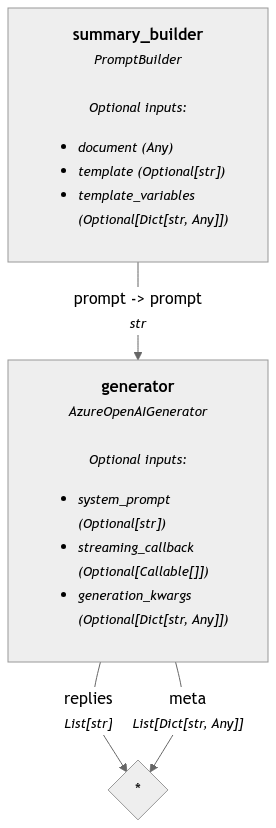

In [ ]:
self.pipeline.show()

In [ ]:
from haystack import self.pipeline, Predefinedself.pipeline


In [62]:
load_dotenv()

True

In [64]:
os.environ["AZURE_DOC_ENDPOINT"]

'https://ivd-doc.cognitiveservices.azure.com/'

In [63]:
@component
class SummaryKeywordPipeLine:
  """
  A component extract document summary and keywords
  """
  def __init__(self):
    self.pipeline = Pipeline()
    summary_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
    summary_template = "Give me main points of my documents. Documents:\n  {{ document }}"
    keyword_client = AzureOpenAIGenerator(azure_endpoint=os.getenv("AZURE_ENDPOINT"),
                        api_key=Secret.from_token(os.getenv("AZURE_OPENAI_KEY")),
                        azure_deployment=os.getenv("CHAT_COMPLETIONS_MODEL"))
    keyword_template = "Give me list of keywords of my documents. Example: \n{{example_extract_keywords}}\nResult:{{keywords_sample}}} Documents:\n  {{ document }}\nResults:"
    summary_builder = PromptBuilder(template=summary_template)
    keyword_builder = PromptBuilder(template=keyword_template)
    self.pipeline.add_component("summary_builder", summary_builder)
    self.pipeline.add_component("summary_generator", summary_client)
    self.pipeline.add_component("keyword_builder", keyword_builder)
    self.pipeline.add_component("keyword_generator", keyword_client)
    self.pipeline.connect("summary_builder", "summary_generator")
    self.pipeline.connect("keyword_builder", "keyword_generator")
    
  @component.output_types(docs=list[Document])
  def run(self,docs=list[Document]):
    example_extract_keywords = """Documents:
    Cloud computing allows users to access computing resources over the internet. It provides scalable and flexible computing services, such as storage, networking, and databases. There are several types of cloud computing: public, private, and hybrid. With cloud computing, users can deploy applications, store data, and perform computing tasks without owning or maintaining the physical infrastructure."""
    keywords_sample = ["cloud computing", "scalability", "flexibility", "public cloud", "private cloud", "hybrid cloud", "internet resources"]
    for doc in docs:
      results=self.pipeline.run({"summary_builder": {"document": doc.content},"keyword_builder": {"document": doc.content,"example_extract_keywords": example_extract_keywords,"keywords_sample": keywords_sample}},include_outputs_from=["summary_generator","keyword_generator"])
      doc.meta={"summary":results["summary_generator"]["replies"][0],"keywords":results["keyword_generator"]["replies"][0]}
    return docs

class DocumentPipeline(Pipeline):
    def __init__(self):
        super().__init__()
        self.document_store = ElasticsearchDocumentStore()
        self.add_component("converter", AzureOCRDocumentConverter(endpoint=os.environ["AZURE_DOC_ENDPOINT"], api_key=Secret.from_token(os.environ["AZURE_DOC_KEY"])))
        self.add_component("cleaner", DocumentCleaner())
        self.add_component("splitter", DocumentSplitter(split_by="passage", split_length=5))
        self.add_component("summary_keyword", SummaryKeywordPipeLine())
        # self.add_component("writer", DocumentWriter(document_store=self.document_store))
        self.connect("converter", "cleaner")
        self.connect("cleaner", "splitter")
        self.connect("splitter", "summary_keyword")
        # self.connect("summary_keyword", "writer")

In [58]:
doc_pipeline = DocumentPipeline()
doc_pipeline.show()

KeyError: 'AZURE_DOC_ENDPOINT'

In [ ]:
self.pipeline_1 = self.pipeline.from_template(Predefinedself.pipeline.INDEXING)

PipelineUnmarshalError: Error unmarshalling pipeline: Couldn't deserialize component 'embedder' of class 'OpenAIDocumentEmbedder' with the following data: {'init_parameters': {'api_base_url': None, 'api_key': EnvVarSecret(_env_vars=('OPENAI_API_KEY',), _strict=True, _type=<SecretType.ENV_VAR: 'env_var'>), 'batch_size': 32, 'dimensions': None, 'embedding_separator': '\\n', 'meta_fields_to_embed': [], 'model': 'text-embedding-ada-002', 'organization': None, 'prefix': '', 'progress_bar': True, 'suffix': ''}, 'type': 'haystack.components.embedders.openai_document_embedder.OpenAIDocumentEmbedder'}. Possible reasons include malformed serialized data, mismatch between the serialized component and the loaded one (due to a breaking change, see https://github.com/deepset-ai/haystack/releases), etc.
Source:
---

components:
  cleaner:
    init_parameters:
      remove_empty_lines: true
      remove_extra_whitespaces: true
      remove_regex: null
      remove_repeated_substrings: false
      remove_substrings: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner

  converter:
    init_parameters:
      encoding: utf-8
    type: haystack.components.converters.txt.TextFileToDocument

  embedder:
    init_parameters:
      api_base_url: null
      api_key:
        env_vars:
        - OPENAI_API_KEY
        strict: true
        type: env_var
      batch_size: 32
      dimensions: null
      embedding_separator: '\n'
      meta_fields_to_embed: []
      model: text-embedding-ada-002
      organization: null
      prefix: ''
      progress_bar: true
      suffix: ''
    type: haystack.components.embedders.openai_document_embedder.OpenAIDocumentEmbedder

  splitter:
    init_parameters:
      split_by: word
      split_length: 200
      split_overlap: 0
    type: haystack.components.preprocessors.document_splitter.DocumentSplitter

  writer:
    init_parameters:
      document_store:
        init_parameters:
          bm25_tokenization_regex: (?u)\b\w\w+\b
          bm25_algorithm: BM25L
          bm25_parameters: {}
          embedding_similarity_function: dot_product
          index: documents
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      policy: NONE
    type: haystack.components.writers.document_writer.DocumentWriter

connections:
- receiver: cleaner.documents
  sender: converter.documents
- receiver: splitter.documents
  sender: cleaner.documents
- receiver: embedder.documents
  sender: splitter.documents
- receiver: writer.documents
  sender: embedder.documents

metadata: {}